The Land Surface Climate in the Regional Arctic System Model
=====
**Joe Hamman, Bart Nijssen**

*Department of Civil and Environmental Engineering, University of Washington, Seattle, WA, USA*

**Dennis Lettenmier**

*Department of Geography, University of California Los Angeles, Los Angeles, CA, USA*

**Wieslaw Maslowski, …others…**

*Department of Oceanography, Naval Postgraduate School, Monterey, CA, USA*

## Abstract:
The Arctic region is expected to experience disproportionately severe impacts due to climate change, affecting sea ice, seasonal snow cover, streamflow, permafrost, glaciers, and ice sheets as well as terrestrial and aquatic ecosystems.  Through the use of the Regional Arctic System Model (RASM), a fully coupled regional earth system model, we aim to better understand how changes in these processes may prompt non-linear responses and feedbacks throughout the Arctic region climate system.  The net effect of these feedbacks is not easily understood without the use of coupled earth system models that allow us to evaluate the interactions between components of the climate system; determine the extent, magnitude, and sign of complex feedback processes; and to project the climate system’s response to future predictions.  RASM is a high resolution, regional, coupled atmosphere - land - sea ice - ocean model that uses the Community Earth System Model (CESM) coupling infrastructure over a Pan-Arctic domain. RASM is composed of the Weather Research and Forecasting (WRF) atmospheric model, the Variable Infiltration Capacity (VIC) hydrology model, the RVIC streamflow routing model, the Parallel Ocean Program (POP) model and the Los Alamos Sea Ice model (CICE).  We evaluate RASM’s abilities to capture key features of the land surface climate and hydrological cycle over the recent decades (1979-2009) through comparisons with uncoupled simulations, reanalysis data sets, satellite measurements and in-situ observations. Of particular interest are the model’s ability to capture diurnal, seasonal, and interannual variations in hydrological fluxes and states and the interaction between model components.

This notebook contains the code and figures used in this paper. 


In [1]:
%matplotlib inline

In [2]:
# Reguired libraries
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.basemap import cm as basemap_cm
import seaborn as sns
from collections import OrderedDict
from netCDF4 import num2date
from scipy.stats import ranksums, ttest_ind
from scipy.spatial import ConvexHull
from datetime import datetime
from calendar import month_abbr, month_name
from netCDF4 import date2num, num2date

# For temporary display of existing figures
from IPython.display import Image

# RASM lib plotting utilities
from rasmlib.calendar import dpm
from rasmlib.analysis.climatology import season_mean, annual_mean
from rasmlib.analysis.plotting import cmap_discretize, sub_plot_pcolor, projections, default_map, make_bmap, seasons

# Set some general plotting values
fontsize = 7
dpi = 200 # set to 900 for final publication
mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Myriad Pro') 
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['mathtext.default'] = 'sf'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42

fill_color = (0.9, 0.9, 0.9)


In [3]:
ncfiles = {}
# Grid and domain files
ncfiles['lnd_domain'] = '/raid2/jhamman/projects/RASM/data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.100920.nc'
ncfiles['ocn_domain'] = '/raid2/jhamman/projects/RASM/data/inputdata/CESM/share/domains/domain.ocn.ar9v4.100920.nc'
ncfiles['rasm_lnd_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc'
ncfiles['rasm_atm_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_WRFVIC_GRID_MASKS_AND_METRICS.nc'
ncfiles['rasm_ocn_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc'
ncfiles['rasm_ocn_masks2'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_POPCICE_GRID_MASKS_AND_METRICS.nc'


In [4]:
ncdata = {}
for k, v in ncfiles.items():
    try:
        print(k)
        ncdata[k] = xr.open_dataset(v)
    except:
        print('failed', k)

ocn_domain
rasm_ocn_masks2
lnd_domain
rasm_atm_masks
rasm_lnd_masks
rasm_ocn_masks


In [5]:
re = 6.37122e6
# Add variables or adjust units of datasets if ncessary

# RASM
ncdata['lnd_domain']['area'] *= re * re  # m2


In [6]:
# Setup rasmlib plotting
wr50a_map = make_bmap(projection=projections['wr50a'],
                      lons=ncdata['lnd_domain']['xc'].values,
                      lats=ncdata['lnd_domain']['yc'].values)
spatial_plot_mask = ncdata['rasm_lnd_masks']['mask_active_land'].values < 0.9

In [7]:
ar9v4_map = make_bmap(projection=projections['wr50a'],
                      lons=ncdata['rasm_ocn_masks2']['ULON'].values,
                      lats=ncdata['rasm_ocn_masks2']['ULAT'].values)


In [8]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
def colorbar_index(ncolors, cmap, ticklabels=None):
    cmap = cmap_discretize_2(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, shrink=cbar_shrink, pad=0.01)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    if ticklabels is None:
        colorbar.set_ticklabels(range(ncolors))
    else:
        colorbar.set_ticklabels(ticklabels)
    return colorbar

def cmap_discretize_2(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in range(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [9]:
r_arctic_attrs = pd.read_pickle('../../../data/notebooks/r-arctic_attrs.pkl')

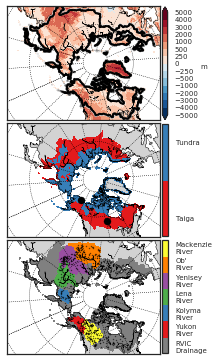

In [10]:
sns.set_style("white")
fig, axes = plt.subplots(figsize=(3.25, 4.875), ncols=1, nrows=3, dpi=dpi)

cbar_shrink = 0.99

# subplot0: land/ocean domains with elevation and drainage basin
plt.sca(axes[0])
# axes[0].set_title('Regional Arctic System Model Configuration')
ticks = [-5000, -4000, -3000, -2000, -1000, -500, -250, 0,
         250, 500, 1000, 2000, 3000, 4000, 5000]
cmap = cmap_discretize_2('RdBu_r', len(ticks))
norm = mpl.colors.BoundaryNorm(ticks, cmap.N)
vmin = -5000
vmax = 5000
wr50a_map.m.fillcontinents(color='lightgrey', lake_color='lightgrey', ax=axes[0], zorder=0)
# ar9v4_map.m.pcolormesh(ar9v4_map.xi, ar9v4_map.yi,
#                        np.ma.masked_where(pop_masks['mask'].values < 1, pop_masks['HT'].values / -100),
#                        vmin=vmin, vmax=vmax, cmap=cmap, ax=axes[0], norm=norm)
mappable = wr50a_map.m.pcolormesh(wr50a_map.xi, wr50a_map.yi,
                                 np.ma.masked_where(ncdata['rasm_lnd_masks']['mask'].values <= 0, ncdata['rasm_atm_masks']['HGT'].values),
                                 vmin=vmin, vmax=vmax, cmap=cmap, ax=axes[0], norm=norm)
wr50a_map.m.contour(wr50a_map.xi, wr50a_map.yi,
                    ncdata['rasm_lnd_masks']['mask_rvic_drainage'],
                    ax=axes[0], color='k')
wr50a_map.m.drawparallels(np.arange(-80., 81., 20.), linewidth=0.5)
wr50a_map.m.drawmeridians(np.arange(-180., 181., 20.), linewidth=0.5)
wr50a_map.m.drawcoastlines(color='k', linewidth=0.5)
cbar = plt.colorbar(mappable, ticks=ticks, shrink=cbar_shrink, pad=0.01, extend='both')
cbar.set_label('m', rotation=0, fontsize=fontsize)
cbar.ax.tick_params(axis='y', which='major', labelsize=fontsize)

# fig.text(.255, .93, 'a', fontweight='roman',
#          bbox=dict(facecolor='none', edgecolor='black', linewidth=1, boxstyle='round'))

# subplot 1: bioclimate zones
plt.sca(axes[1])
wr50a_map.m.fillcontinents(color='lightgrey', lake_color='lightgrey', ax=axes[1], zorder=0)
# axes[1].set_title('Bioclimate Analysis Masks') 
mask_keys = ['mask_boreal_forests_taiga', 'mask_tundra']
titles = ['Taiga', 'Tundra']
current_palette = sns.color_palette(n_colors=len(titles), palette='Set1')

for mask, label, color in zip(mask_keys, titles, current_palette):
    mappable = wr50a_map.m.contourf(wr50a_map.xi, wr50a_map.yi,
                         np.ma.masked_where(ncdata['rasm_lnd_masks'][mask] < 0.00001, ncdata['rasm_lnd_masks'][mask]),
                         ax=axes[1], levels=[0, 1.1], colors=[color, color])
wr50a_map.m.drawparallels(np.arange(-80., 81., 20.), linewidth=0.5)
wr50a_map.m.drawmeridians(np.arange(-180., 181., 20.), linewidth=0.5)
wr50a_map.m.drawcoastlines(color='k', linewidth=0.5)
cmap = mpl.colors.ListedColormap(current_palette)
cbar = colorbar_index(len(titles), cmap, titles)
cbar.ax.tick_params(axis='y', which='major', labelsize=fontsize)
# fig.text(.255, .605, 'b', fontweight='roman',
#          bbox=dict(facecolor='none', edgecolor='black', linewidth=1, boxstyle='round'))
dc_sites = {'Boreas': [29, 179],
            'Happy Valley': [66, 132]}
for k, v in dc_sites.items():
    plt.scatter(wr50a_map.xi[v[0], v[1]], wr50a_map.yi[v[0], v[1]], s=50, marker='o', color='k')

# subplot 2: river basins
# axes[2].set_title('Hydrologic Basin Analysis Masks') 
plt.sca(axes[2])
wr50a_map.m.fillcontinents(color='lightgrey', lake_color='lightgrey', ax=axes[2], zorder=0)
mask_keys = ['mask_rvic_drainage', 'mask_yukon', 'mask_kolyma', 'mask_lena',
             'mask_yenisey', 'mask_ob', 'mask_mackenzie']
titles = ['RVIC\nDrainage', 'Yukon\nRiver', 'Kolyma\nRiver', 'Lena\nRiver',
          'Yenisey\nRiver', 'Ob\'\nRiver', 'Mackenzie\nRiver']
current_palette = sns.color_palette(n_colors=len(titles) - 1, palette='Set1')
current_palette = ['grey'] + current_palette
for mask, label, color in zip(mask_keys, titles, current_palette):
    wr50a_map.m.contourf(wr50a_map.xi, wr50a_map.yi,
                         np.ma.masked_where(ncdata['rasm_lnd_masks'][mask] < 0.00001, ncdata['rasm_lnd_masks'][mask]),
                         ax=axes[2], levels=[0, 1.1], colors=[color, color], color='k')

wr50a_map.m.drawparallels(np.arange(-80., 81., 20.), linewidth=0.5)
wr50a_map.m.drawmeridians(np.arange(-180., 181., 20.), linewidth=0.5)
wr50a_map.m.drawcoastlines(color='k', linewidth=0.5)
cmap = mpl.colors.ListedColormap(current_palette)
cbar = colorbar_index(len(titles), cmap, titles)
cbar.ax.tick_params(axis='y', which='major', labelsize=fontsize)

# fig.text(.255, .28, 'c', fontweight='roman',
#          bbox=dict(facecolor='none', edgecolor='black', linewidth=1, boxstyle='round'))

 
wr50a_map.m.scatter(r_arctic_attrs['Long'].values, r_arctic_attrs['Lat'].values, latlon=True, marker='.', s=5, color='k', alpha=0.5)

plt.tight_layout(pad=0.1)

# fig.savefig('/home/ftp/pub/jhamman/rasm1_land_surface_paper_figs/figure0.pdf')


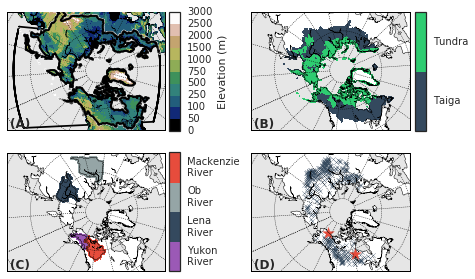

In [11]:
sns.set_style("white")
fig, axes = plt.subplots(figsize=(7.5, 6), ncols=2, nrows=2, dpi=dpi)

cbar_shrink = 0.7

# ---------------------------------------------------------------------------------------------------------------#
# subplot0: land/ocean domains with elevation and drainage basin
plt.sca(axes[0, 0])
ticks = [0, 50, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000]
cmap = cmap_discretize_2('gist_earth', len(ticks))
norm = mpl.colors.BoundaryNorm(ticks, cmap.N)
vmin = -5000
vmax = 5000
wr50a_map.m.fillcontinents(color='white', lake_color='white', ax=axes[0, 0], zorder=0)
wr50a_map.m.drawmapboundary(fill_color=fill_color, ax=axes[0, 0], zorder=0)

ys, xs = np.nonzero(ncdata['rasm_ocn_masks2']['mask'].values > 0) 
points = np.array([ar9v4_map.xi[ys, xs], ar9v4_map.yi[ys, xs]]).T
hull = ConvexHull(points)

for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'k-', zorder=0)
    
mappable = wr50a_map.m.pcolormesh(wr50a_map.xi, wr50a_map.yi,
                                 np.ma.masked_where(ncdata['rasm_atm_masks']['mask'].values > 0.,
                                                    ncdata['rasm_atm_masks']['HGT'].values),
                                 vmin=vmin, vmax=vmax, cmap=cmap, ax=axes[0, 0], norm=norm)
wr50a_map.m.contour(wr50a_map.xi, wr50a_map.yi,
                    ncdata['rasm_lnd_masks']['mask_rvic_drainage'],
                    ax=axes[0, 0], color='k')
wr50a_map.m.drawparallels(np.arange(-80., 81., 20.), linewidth=0.5)
wr50a_map.m.drawmeridians(np.arange(-180., 181., 20.), linewidth=0.5)
wr50a_map.m.drawcoastlines(color='k', linewidth=0.5)
# cbar = plt.colorbar(mappable, ticks=ticks, shrink=cbar_shrink, pad=0.01, extend='both')
# cbar.set_label('m', rotation=0, fontsize=fontsize)
# cbar.ax.tick_params(axis='y', which='major', labelsize=fontsize)

ax1 = fig.add_axes([0.44, 0.625, 0.02, 0.275])
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, ticks=ticks,
                                orientation='vertical',
                                extend='neither')
cb1.set_label('Elevation (m)')
# ---------------------------------------------------------------------------------------------------------------#
# subplot 1: bioclimate zones
plt.sca(axes[0, 1])
wr50a_map.m.fillcontinents(color='white', lake_color='white', ax=axes[0, 1], zorder=0)
wr50a_map.m.drawmapboundary(fill_color=fill_color, ax=axes[0, 1], zorder=0)
mask_keys = ['mask_boreal_forests_taiga', 'mask_tundra']
titles = ['Taiga', 'Tundra']
current_palette = sns.color_palette(n_colors=len(titles), palette='Set1')
current_palette = ["#34495e", "#2ecc71"]

for mask, label, color in zip(mask_keys, titles, current_palette):
    mappable = wr50a_map.m.contourf(wr50a_map.xi, wr50a_map.yi,
                         np.ma.masked_where(ncdata['rasm_lnd_masks'][mask] < 0.00001, ncdata['rasm_lnd_masks'][mask]),
                         ax=axes[0, 1], levels=[0, 1.1], colors=[color, color])
wr50a_map.m.drawparallels(np.arange(-80., 81., 20.), linewidth=0.5)
wr50a_map.m.drawmeridians(np.arange(-180., 181., 20.), linewidth=0.5)
wr50a_map.m.drawcoastlines(color='k', linewidth=0.5)
ax1 = fig.add_axes([0.895, 0.625, 0.02, 0.275])
cmap = mpl.colors.ListedColormap(current_palette)
norm = mpl.colors.BoundaryNorm(np.arange(cmap.N + 1), cmap.N + 1)
cbar = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm,
                                 ticks=np.arange(cmap.N) + 0.5,
                                 orientation='vertical',
                                 extend='neither')
cbar.set_ticklabels(titles)

# ---------------------------------------------------------------------------------------------------------------#
# subplot 2: river basins
plt.sca(axes[1, 0])
wr50a_map.m.fillcontinents(color='white', lake_color='white', ax=axes[1, 0], zorder=0)
wr50a_map.m.drawmapboundary(fill_color=fill_color, ax=axes[1, 0], zorder=0)

mask_keys = ['mask_yukon', 'mask_lena',
             'mask_ob', 'mask_mackenzie']
titles = ['Yukon\nRiver', 'Lena\nRiver',
          'Ob\nRiver', 'Mackenzie\nRiver']
current_palette = sns.color_palette(n_colors=len(titles), palette='Set1')
current_palette = ["#9b59b6", "#34495e", "#95a5a6", "#e74c3c"]
for mask, label, color in zip(mask_keys, titles, current_palette):
    data = np.ma.masked_where(ncdata['rasm_lnd_masks'][mask] < 0.00001, ncdata['rasm_lnd_masks'][mask])
    cs = wr50a_map.m.contourf(wr50a_map.xi, wr50a_map.yi, data,
                              ax=axes[1, 0], levels=[0, 1.1], colors=[color, color], color='k')
    cs = wr50a_map.m.contour(wr50a_map.xi, wr50a_map.yi, data, ax=axes[1, 0], levels=[0, 0.99],
                             colors='k', linewidths = (0.5, ), zorder=100, hold='on')

wr50a_map.m.drawparallels(np.arange(-80., 81., 20.), linewidth=0.5)
wr50a_map.m.drawmeridians(np.arange(-180., 181., 20.), linewidth=0.5)
wr50a_map.m.drawcoastlines(color='k', linewidth=0.5)
ax1 = fig.add_axes([0.44, 0.3, 0.02, 0.275])
cmap = mpl.colors.ListedColormap(current_palette)
norm = mpl.colors.BoundaryNorm(np.arange(cmap.N + 1), cmap.N + 1)
cbar = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm,
                                 ticks=np.arange(cmap.N) + 0.5,
                                 orientation='vertical',
                                 extend='neither')
cbar.set_ticklabels(titles)
# ---------------------------------------------------------------------------------------------------------------#
# Subplot 3: in-situ sites
plt.sca(axes[1, 1])
wr50a_map.m.fillcontinents(color='white', lake_color='white', ax=axes[1, 1], zorder=0)
wr50a_map.m.drawmapboundary(fill_color=fill_color, ax=axes[1, 1], zorder=0)
wr50a_map.m.drawparallels(np.arange(-80., 81., 20.), linewidth=0.5)
wr50a_map.m.drawmeridians(np.arange(-180., 181., 20.), linewidth=0.5)
wr50a_map.m.drawcoastlines(color='k', linewidth=0.5)

dc_sites = {'Boreas': [29, 179],
            'Happy Valley': [66, 132]}
  
wr50a_map.m.scatter(r_arctic_attrs['Long'].values, r_arctic_attrs['Lat'].values, latlon=True, marker='x', s=20, color="#34495e")

for k, v in dc_sites.items():
    plt.scatter(wr50a_map.xi[v[0], v[1]], wr50a_map.yi[v[0], v[1]], s=150, marker='*', color="#e74c3c")

axes[0, 0].annotate('(A)', (0.02, 0.02), fontsize=12, xycoords="axes fraction", fontweight='bold')
axes[0, 1].annotate('(B)', (0.02, 0.02), fontsize=12, xycoords="axes fraction", fontweight='bold')
axes[1, 0].annotate('(C)', (0.02, 0.02), fontsize=12, xycoords="axes fraction", fontweight='bold')  
axes[1, 1].annotate('(D)', (0.02, 0.02), fontsize=12, xycoords="axes fraction", fontweight='bold')

fig.subplots_adjust(wspace=0.4, bottom=0.3)

# fig.savefig('/home/ftp/pub/jhamman/rasm1_land_surface_paper_figs/figure0.pdf')
plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Figure_01.png'), dpi=dpi, bbox_inches='tight')

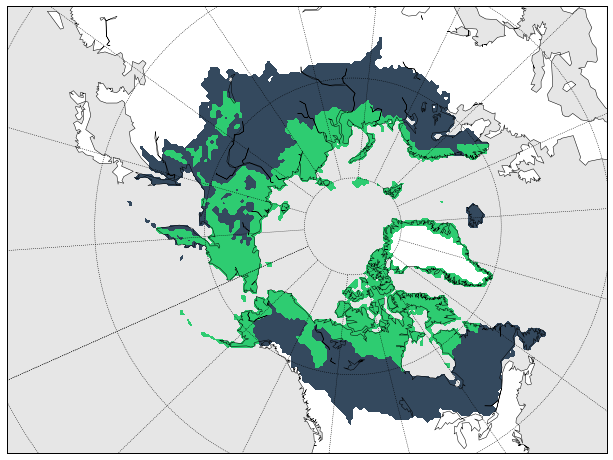

In [12]:
# subplot 1: bioclimate zones
fig, ax = plt.subplots(figsize=(12, 8))
wr50a_map.m.fillcontinents(color='white', lake_color='white', ax=ax, zorder=0)
wr50a_map.m.drawmapboundary(fill_color=fill_color, ax=ax, zorder=0)
mask_keys = ['mask_boreal_forests_taiga', 'mask_tundra']
titles = ['Taiga', 'Tundra']
current_palette = sns.color_palette(n_colors=len(titles), palette='Set1')
current_palette = ["#34495e", "#2ecc71"]

for mask, label, color in zip(mask_keys, titles, current_palette):
    mappable = wr50a_map.m.contourf(wr50a_map.xi, wr50a_map.yi,
                         np.ma.masked_where(ncdata['rasm_lnd_masks'][mask] < 0.00001, ncdata['rasm_lnd_masks'][mask]),
                         levels=[0, 1.1], colors=[color, color])
wr50a_map.m.drawparallels(np.arange(-80., 81., 20.), linewidth=0.5)
wr50a_map.m.drawmeridians(np.arange(-180., 181., 20.), linewidth=0.5)
wr50a_map.m.drawcoastlines(color='k', linewidth=0.5)
# ax1 = fig.add_axes([0.87, 0.14, 0.02, 0.75])
# cmap = mpl.colors.ListedColormap(current_palette)
# norm = mpl.colors.BoundaryNorm(np.arange(cmap.N + 1), cmap.N + 1)
# cbar = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm,
#                                  ticks=np.arange(cmap.N) + 0.5,
#                                  orientation='vertical',
#                                  extend='neither')
# cbar.set_ticklabels(titles)
fig.savefig('tundra_taiga_masks.pdf')

In [13]:
import cartopy.crs as ccrs
# projection class
class Rasm(ccrs.Projection):

    def __init__(self):

        proj4_params = {'R': 6371200.0,
                        'lat_0': 90.0,
                        'lat_1': 90,
                        'lat_2': 90,
                        'lon_0': -114.0+360,
                        'proj': 'lcc',
                        'units': 'm',
                        'x_0': 9469302.950316086,
                        'y_0': 6201952.603370549}

        super(Rasm, self).__init__(proj4_params)

    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))

        return ccrs.sgeom.Polygon(coords).exterior

    @property
    def threshold(self):
        return 100000.0

    @property
    def x_limits(self):
        return (0, 16423961.103252266)

    @property
    def y_limits(self):
        return (0, 12228062.194885937)

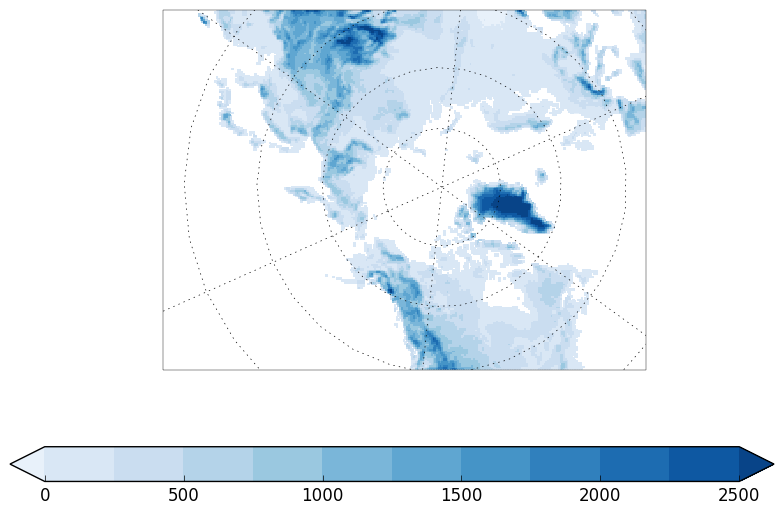

In [14]:
import seaborn as sns
sns.set_style('white')

elev = ncdata['rasm_atm_masks']['HGT'].where(ncdata['rasm_atm_masks'].mask == 0)

plt.figure()
ax = plt.subplot(projection=Rasm())
mappable = elev.plot.pcolormesh('longitude', 'latitude', transform=ccrs.PlateCarree(),
                                vmin=0, vmax=2500, cmap='Blues', add_colorbar=False, levels=10)
ax.gridlines()
plt.colorbar(mappable, orientation='horizontal')
plt.tight_layout()



In [15]:
from shapely.geometry import Point, Polygon, MultiPoint
import geopandas

In [17]:
points.shape

(562021, 2)

In [ ]:
ys, xs = np.nonzero(ncdata['rasm_lnd_masks']['mask_rvic_drainage'].values > 0) 
points = np.array([ncdata['rasm_lnd_masks']['xc'].values[ys, xs],
                   ncdata['rasm_lnd_masks']['yc'].values[ys, xs]]).T
points = np.where(points > 180, points - 360, points)
mpoints = MultiPoint(points=points)
land_hull = mpoints.convex_hull
land_boundary = geopandas.GeoSeries(land_hull).boundary

In [ ]:
gdf = geopandas.GeoDataFrame({'ocean': ocean_boundary, 'land': land_boundary})

In [ ]:
full_boundary = ocean_boundary.union(land_boundary)

In [ ]:
import seaborn as sns
sns.set_style('white')

elev = ncdata['rasm_atm_masks']['HGT'].where(ncdata['rasm_atm_masks'].mask == 0)

plt.figure()
ax = plt.subplot(projection=Rasm())
mappable = elev.plot.pcolormesh('longitude', 'latitude', transform=ccrs.PlateCarree(),
                                vmin=0, vmax=2500, cmap='Blues', add_colorbar=False, levels=10)
ax.gridlines()
plt.colorbar(mappable, orientation='horizontal')
plt.tight_layout()

ax.add_geometries([land_boundary.geometry.to_crs({'proj': 'latlon'})], ccrs.PlateCarree())

In [ ]:
land_boundary.plot()